In [1]:
%gui qt
%matplotlib_svg
import numpy as np
import pylab as pl
import cv2
from cv2 import cv
from numpy import fft

In [2]:
# %matplotlib

Using matplotlib backend: Qt4Agg


## 图像变换

### 几何变换

warpAffine(): 对图像进行仿射变换, 主要参数是仿射变换矩阵M(2x3)

In [ ]:
img = cv2.imread("lena.jpg")
h, w = img.shape[:2]
src = np.array([[0, 0], [w - 1, 0], [0, h - 1]], dtype=np.float32)  #❶
dst = np.array([[300, 300], [873, 78], [161, 923]], dtype=np.float32)  #❷

m = cv2.getAffineTransform(src, dst)  #
result = cv2.warpAffine(
    img, m, (2 * w, 2 * h), borderValue=(255, 255, 255, 255))  #

In [ ]:
fig, ax = pl.subplots(figsize=(4, 4))
fig.subplots_adjust(0, 0, 1, 1)
ax.set_xlim(-5, w * 2 + 5)
ax.set_ylim(h * 2 + 5, -5)
ax.axis("off")
ax.imshow(result[:, :, ::-1])
ax.imshow(img[:, :, ::-1], alpha=0.4)
p = np.vstack((src, src[:1]))
ax.plot(p[:, 0], p[:, 1], "-o", alpha=0.5)
from matplotlib.patches import FancyArrowPatch
for p1, p2 in zip(src, dst):
    arrow = FancyArrowPatch(p1, p2, transform=ax.transData,
                            color="gray", mutation_scale=10)
    ax.add_artist(arrow)

warpPerspective(): 对图像进行透射变换,透射矩阵是3x3的矩阵

In [ ]:
src = np.array(
    [[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float32)
dst = np.array(
    [[300, 350], [800, 300], [900, 923], [161, 923]], dtype=np.float32)

m = cv2.getPerspectiveTransform(src, dst)
result = cv2.warpPerspective(
    img, m, (2 * w, 2 * h), borderValue=(255, 255, 255, 255))

In [ ]:
fig, ax = pl.subplots(figsize=(4, 4))
fig.subplots_adjust(0, 0, 1, 1)
ax.set_xlim(-5, w * 2 + 5)
ax.set_ylim(h * 2 + 5, -5)
ax.axis("off")
ax.imshow(result[:, :, ::-1])
ax.imshow(img[:, :, ::-1], alpha=0.4)
p = np.vstack((src, src[:1]))
ax.plot(p[:, 0], p[:, 1], "-o", alpha=0.5)
from matplotlib.patches import FancyArrowPatch
for p1, p2 in zip(src, dst):
    arrow = FancyArrowPatch(p1, p2, transform=ax.transData,
                            color="gray", mutation_scale=10)
    ax.add_artist(arrow)

> `scpy2.opencv.warp_demo`：仿射变换和透视变换的演示程序，可以通过鼠标拖拽图中蓝色三角形和四边形的顶点，从而决定原始图像各个顶角经过变换之后的坐标。

In [ ]:
%exec_python -m scpy2.opencv.warp_demo

### 重映射-remap

remap(): 通用的图像映射函数, 将原始像素点映射到另外的位置

In [ ]:
mapy, mapx = np.mgrid[0:h * 3:3, 0:w * 2:2]
img2 = cv2.remap(img, mapx.astype("f32"), mapy.astype("f32"), cv2.INTER_LINEAR)
x, y = 12, 40 #用于验证映射公式的坐标点
assert np.all(img[mapy[y, x], mapx[y, x]] == img2[y, x])

使用三维曲面和remap()对图片进行变形: 将图像贴在曲面上

In [39]:
def make_surf_map(func, r, w, h, d0):
    """计算曲面函数func在[-r:r]范围之上的值，并进行透视投影。
    视点高度为曲面高度的d0倍+1"""
    y, x = np.ogrid[-r:r:h * 1j, -r:r:w * 1j]
    z = func(x, y) + 0 * (x + y)  # 
    d = d0 * np.ptp(z) + 1.0  # 
    map1 = x * (d - z) / d  # 
    map2 = y * (d - z) / d
    return (map1 / (2 * r) + 0.5) * w, (map2 / (2 * r) + 0.5) * h  # ❹

def make_func(expr_str):
    def f(x, y):
        return eval(expr_str, np.__dict__, locals())
    return f

def get_latex(expr_str):
    import sympy
    x, y = sympy.symbols("x, y")
    env = {"x": x, "y": y}
    expr = eval(expr_str, sympy.__dict__, env)
    return sympy.latex(expr)

settings = [
    ("sqrt(8.1 - x**2 - y**2)", 2, 1),
    ("sin(6*sqrt(x**2+y**2))", 10.1, 10.1),
    ("0", 2, 0.5)
]
fig, axes = pl.subplots(1, len(settings), figsize=(6, 6.0 / len(settings)))

img = cv2.imread("br.jpg")
h, w = img.shape[:2]

for ax, (expr, r, height) in zip(axes, settings):
    mapx, mapy = make_surf_map(make_func(expr), r, w, h, height)
    img2 = cv2.remap(
        img, mapx.astype("f32"), mapy.astype("f32"), cv2.INTER_LINEAR)
    ax.imshow(img2[:, :, ::-1])
    ax.axis("off")
    ax.set_title("${}$".format(get_latex(expr)))

fig.subplots_adjust(0, 0, 1, 1, 0.02, 0)

使用remap()还可以实现图像拖拽效果

In [44]:
img = cv2.imread("lena.jpg")
h, w = img.shape[:2]
gridy, gridx = np.mgrid[:h, :w]  # 
tx, ty = 313, 316
sx, sy = 340, 332
r = 40.0
sigma = 20

mask = ((gridx - sx) ** 2 + (gridy - sy) ** 2) < r ** 2  # 
offsetx = np.zeros((h, w))
offsety = np.zeros((h, w))
offsetx[mask] = tx - sx  # 
offsety[mask] = ty - sy
offsetx_blur = cv2.GaussianBlur(offsetx, (0, 0), sigma)  # 
offsety_blur = cv2.GaussianBlur(offsety, (0, 0), sigma)
img2 = cv2.remap(img,
                 (offsetx_blur + gridx).astype("f4"),
                 (offsety_blur + gridy).astype("f4"), cv2.INTER_LINEAR)

(-0.5, 511.5, 511.5, -0.5)

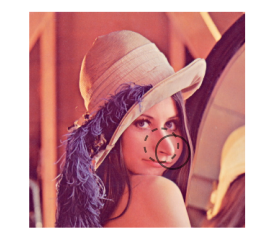

In [48]:
fig, ax = pl.subplots(1, 1, figsize=(3, 3))
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
ax.imshow(img2[:, :, ::-1])
circle = pl.Circle((tx, ty), r, fill=None, alpha=0.5, lw=2, ls="dashed")
ax.add_artist(circle)
circle = pl.Circle((sx, sy), r, fill=None, alpha=0.5, lw=2, color="black")
ax.add_artist(circle)
ax.axis("off")

> `scpy2.opencv.remap_demo`：演示`remap()`的拖拽效果。在图像上按住鼠标左键进行拖拽，每次拖拽完成之后，都将修改原始图像，可以按鼠标右键撤销上次的拖拽操作。

In [ ]:
%exec_python -m scpy2.opencv.remap_demo

### 直方图

histogram(),histogram2d(), Numpy中的直方图统计函数

P:\winpython\WinPython-32bit-2.7.9.2\python-2.7.9\lib\site-packages\matplotlib\font_manager.py:1282: UserWarning: findfont: Font family [u'WenQuanYi Micro Hei'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


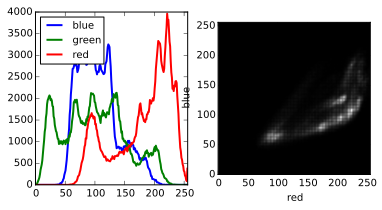

In [2]:
# `lena.jpg`的三个通道的直方图统计、通道0和通道2的二维直方图统计
img = cv2.imread("lena.jpg")
fig, ax = pl.subplots(1, 2, figsize=(6, 3))
colors = ["blue", "green", "red"]

for i in range(3):
    hist, x = np.histogram(img[:,:, i].ravel(), bins=256, range=(0, 256)) #❶
    ax[0].plot(0.5 * (x[:-1] + x[1:]), hist, label=colors[i], color=colors[i])

ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 256)
hist2, x2, y2 = np.histogram2d(  # 
    img[:,:, 0].ravel(), img[:,:, 2].ravel(), 
    bins=(100, 100), range=[(0, 256), (0, 256)])
ax[1].imshow(hist2, extent=(0, 256, 0, 256), origin="lower", cmap="gray")
ax[1].set_ylabel("blue")
ax[1].set_xlabel("red");

calcHist(), Opencv中的直方图统计函数

In [6]:
result = cv2.calcHist([img],
                      channels=(0, 1, 2),
                      mask = None,
                      histSize = (30, 20, 10),
                      ranges = (0, 256, 0, 256, 0, 256))
result.shape

(30, 20, 10)

#### 直方图反向映射

calcBackProject(), 可以将图像中的每点替换为它在直方图中所对应的值, 通过这种变换, 直方图中出现次数越高的像素,在新图像中越亮

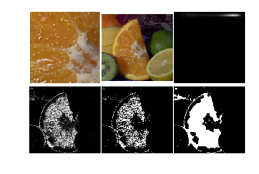

In [8]:
#%fig=使用calcBackProject()寻找图像中橙子部分
img = cv2.imread("fruits_section.jpg")  # 
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

result = cv2.calcHist([img_hsv], [0, 1], None,  # 
                      [40, 40], [0, 256, 0, 256])

result /= np.max(result) / 255  # 

img2 = cv2.imread("fruits.jpg")  # 
img_hsv2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

img_bp = cv2.calcBackProject([img_hsv2],  # ❺
                             channels=[0, 1],
                             hist=result,
                             ranges=[0, 256, 0, 256],
                             scale=1)
_, img_th = cv2.threshold(img_bp, 180, 255, cv2.THRESH_BINARY)  # ❻
struct = np.ones((3, 3), np.uint8)
img_mp = cv2.morphologyEx(img_th, cv2.MORPH_CLOSE, struct, iterations=5)  # ❼
#%hide
fig, axes = pl.subplots(2, 3, figsize=(3, 2))
fig.subplots_adjust(0, 0, 1, 1, 0.01, 0.01)
axes[0, 0].imshow(img[:, :, ::-1])
axes[0, 1].imshow(img2[:, :, ::-1])
axes[0, 2].imshow(result[:], cmap="gray")
axes[1, 0].imshow(img_bp[:], cmap="gray")
axes[1, 1].imshow(img_th[:], cmap="gray")
axes[1, 2].imshow(img_mp[:], cmap="gray")

for axe in axes.flat:
    axe.axis("off")

#### 直方图匹配

直方图匹配: 将一幅图像的直方图分布复制给另一幅图像

In [9]:
def histogram_match(src, dst):
    res = np.zeros_like(dst)
    cdf_src = np.zeros((3, 256))
    cdf_dst = np.zeros((3, 256))
    cdf_res = np.zeros((3, 256))
    kw = dict(bins=256, range=(0, 256), normed=True)

    for ch in (0, 1, 2):
        hist_src, _ = np.histogram(src[:, :, ch], **kw)  # 
        hist_dst, _ = np.histogram(dst[:, :, ch], **kw)
        cdf_src[ch] = np.cumsum(hist_src)  # 
        cdf_dst[ch] = np.cumsum(hist_dst)
        index = np.searchsorted(cdf_src[ch], cdf_dst[ch], side="left")  # ❸
        np.clip(index, 0, 255, out=index)  # 
        res[:, :, ch] = index[dst[:, :, ch]]  # 
        hist_res, _ = np.histogram(res[:, :, ch], **kw)
        cdf_res[ch] = np.cumsum(hist_res)

    return res, (cdf_src, cdf_dst, cdf_res)

In [10]:
src = cv2.imread("autumn.jpg")
dst = cv2.imread("summer.jpg")

res, cdfs = histogram_match(src, dst)

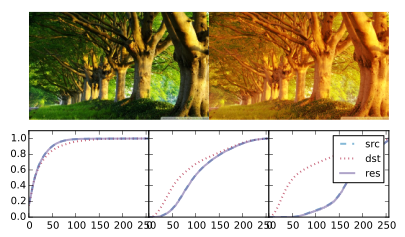

In [13]:
#直方图匹配结果
fig = pl.figure(figsize=(5, 3))
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
ax1 = pl.subplot2grid((5, 6), (0, 0), 3, 3)
ax2 = pl.subplot2grid((5, 6), (0, 3), 3, 3)

ax1.imshow(dst[:,:,::-1])
ax2.imshow(res[:,:,::-1])
ax1.axis("off")
ax2.axis("off")

axb = pl.subplot2grid((5, 6), (3, 0), 2, 2)
axg = pl.subplot2grid((5, 6), (3, 2), 2, 2)
axr = pl.subplot2grid((5, 6), (3, 4), 2, 2)

axg.set_yticklabels([])
axr.set_yticklabels([])

for ax, cdf in zip((axb, axg, axr), zip(*cdfs)): #cdfs是个三元组,**可将其解开
    ax.plot(cdf[0], alpha=0.6, label="src", ls="--")
    ax.plot(cdf[1], alpha=0.6, label="dst", ls=":")
    ax.plot(cdf[2], alpha=0.6, label="res")
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 1.1)
ax.legend()

### 二维离散傅立叶变换

傅里叶变换可以实现空域信号和频域信号的相互转化

In [20]:
from numpy import fft
x = np.random.rand(8, 8)
X = fft.fft2(x)
print np.allclose(X[1:, 1:], X[7:0:-1, 7:0:-1].conj())  # 共轭复数
print X[::4, ::4] # 虚数为零

True
[[ 33.75976737+0.j  -1.94858865+0.j]
 [  3.39676222+0.j   3.34819102+0.j]]


In [15]:
x2 = fft.ifft2(X) # 将频域信号转换回空域信号
np.allclose(x, x2) # 和原始信号进行比较

True

In [21]:
#%fig=（左上）用fft2()计算的频域信号，（中上）使用fftshift()移位之后的频域信号，（其它）各个领域所对应的空域信号
N = 256
img = cv2.imread("lena.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (N, N))
img_freq = fft.fft2(img)
img_mag = np.log10(np.abs(img_freq))
img_mag_shift = fft.fftshift(img_mag)

rects = [(80, 125, 85, 130), (90, 90, 95, 95),
         (150, 10, 250, 250), (110, 110, 146, 146)]

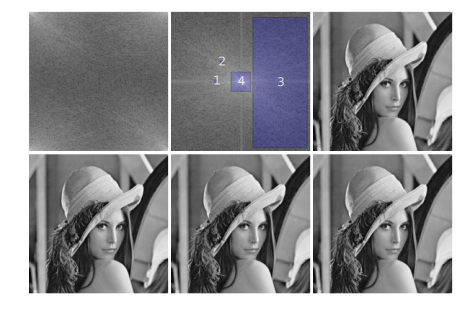

In [25]:
#%fig=(左上)用fft2()计算的频域信号，(中上)使用fftshift()移位之后的频域信号，(其它)各个领域所对应的空域信号
filtered_results = []
for i, (x0, y0, x1, y1) in enumerate(rects):
    mask = np.zeros((N, N), dtype=np.bool)  # ❶
    mask[x0:x1 + 1, y0:y1 + 1] = True  # ❷
    mask[N - x1:N - x0 + 1, N - y1:N - y0 + 1] = True  # ❸
    mask = fft.fftshift(mask)  # ❹
    img_freq2 = img_freq * mask  # ❺
    img_filtered = fft.ifft2(img_freq).real  # ❻
    filtered_results.append(img_filtered)
#%hide
fig, axes = pl.subplots(2, 3, figsize=(6, 4))
axes = axes.ravel()
axes[0].imshow(img_mag, cmap=pl.cm.gray)
axes[1].imshow(img_mag_shift, cmap=pl.cm.gray)

ax = axes[1]
for i, (x0, y0, x1, y1) in enumerate(rects):
    r = pl.Rectangle((x0, y0), x1 - x0, y1 - y0, alpha=0.2)
    ax.add_artist(r)
    pl.text((x0 + x1) / 2, (y0 + y1) / 2, str(i + 1), color="white",
            transform=ax.transData, ha="center", va="center", alpha=0.8)

for ax, result in zip(axes[2:], filtered_results):
    ax.imshow(result, cmap=pl.cm.gray)

for ax in axes:
    ax.set_axis_off()

fig.subplots_adjust(0.01, 0.01, 0.99, 0.99, 0.02, 0.02)

> `scpy2.opencv.fft2d_demo`：演示二维离散傅立叶变换，用户在左侧的频域模值图像上用鼠标绘制遮罩区域，右侧的图像为频域信号经过遮罩处理之后所转换成的空域信号。

In [26]:
%exec_python -m scpy2.opencv.fft2d_demo

### 用双目视觉图像计算深度信息

In [2]:
img_left = cv2.pyrDown(cv2.imread('aloeL.jpg'))
img_right = cv2.pyrDown(cv2.imread('aloeR.jpg'))

img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

stereo_parameters = dict(
    SADWindowSize = 5,
    numDisparities = 192,
    preFilterCap = 4,
    minDisparity = -24,
    uniquenessRatio = 1,
    speckleWindowSize = 150,
    speckleRange = 2,
    disp12MaxDiff = 10,
    fullDP = False,
    P1 = 600,
    P2 = 2400)

stereo = cv2.StereoSGBM(**stereo_parameters)
disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16

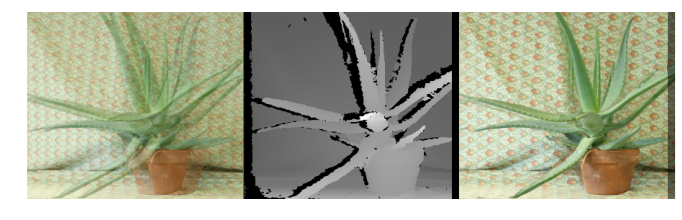

In [3]:
#%fig=用remap重叠左右两幅图像
h, w = img_left.shape[:2]
ygrid, xgrid = np.mgrid[:h, :w]
ygrid = ygrid.astype(np.float32)
xgrid = xgrid.astype(np.float32)
res = cv2.remap(img_right, xgrid - disparity, ygrid, cv2.INTER_LINEAR)

fig, axes = pl.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(img_left)
axes[0].imshow(img_right, alpha=0.5)
axes[1].imshow(disparity, cmap="gray")
axes[2].imshow(img_left)
axes[2].imshow(res, alpha=0.5)
for ax in axes:
    ax.axis("off")
fig.subplots_adjust(0, 0, 1, 1, 0, 0);

In [4]:
Bf = w * 0.8
x = (xgrid - w * 0.5)
y = (ygrid - h * 0.5)
d = (disparity + 1e-6)
z = (Bf / d).ravel()
x = (x / d).ravel()
y = -(y / d).ravel()

In [5]:
mask = (z > 0) & (z < 30)
points = np.c_[x, y, z][mask]
colors = img_left.reshape(-1, 3)[mask]

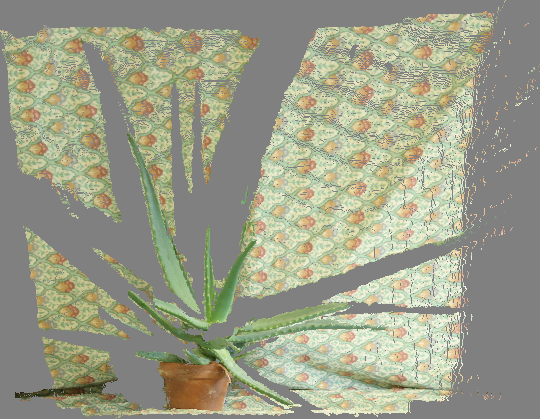

In [6]:
#%fig=使用VTK显示三维点云
from tvtk.api import tvtk
from tvtk.tools import ivtk
from pyface.api import GUI

poly = tvtk.PolyData()
poly.points = points #所有坐标点
poly.verts = np.arange(len(points)).reshape(-1, 1) #所有顶点与坐标点对应
poly.point_data.scalars = colors.astype(np.uint8) #坐标点的颜色，必须使用uint8

m = tvtk.PolyDataMapper()
m.set_input_data(poly)
a = tvtk.Actor(mapper=m) 

from scpy2 import vtk_scene, vtk_scene_to_array
scene = vtk_scene([a], viewangle=22)
scene.camera.position = (0 , 20, -60)
scene.camera.view_up = 0, 1, 0
%array_image vtk_scene_to_array(scene)

> **SOURCE**

> `scpy2.opencv.stereo_demo`：使用双目视觉图像计算深度信息的演示程序。

In [10]:
%gui qt
from scpy2.tvtk.tvtkhelp import ivtk_scene
scene = ivtk_scene([a])
scene.scene.isometric_view()
scene.scene.camera.position = (0 , 20, -50)
scene.scene.camera.view_up = 0, 1, 0

In [27]:
#%hide
%exec_python -m scpy2.opencv.stereo_demo